### Import Libraries

In [6]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Config

In [7]:
# ==========================================
# CONFIGURATION & HYPERPARAMETERS
# ==========================================
HP = {
    # System
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'random_seed': 42,
    
    # Data
    'data_path': '../Implementation/data/ml-latest-small/raw/ml-latest-small/ratings.csv',
    'test_split': 0.2,
    
    # GAT Model Architecture
    'emb_dim': 64,
    'hidden_dim': 32,
    'heads': 4,
    'decoder_dim': 32,
    'n_layers': 2,
    'dropout': 0.1,
    'att_dropout': 0.1,
    
    # Training
    'epochs': 300,
    'lr': 0.005,
    'weight_decay': 1e-4,
    'eval_freq': 5
}

print(f"Using device: {HP['device']}")
torch.manual_seed(HP['random_seed'])

Using device: cpu


In [8]:
# ==========================================
# Data Loading & Preprocessing
# ==========================================
if not os.path.exists(HP['data_path']):
    print(f"Warning: File not found at {HP['data_path']}. Make sure the dataset exists.")
    exit()

ratings = pd.read_csv(HP['data_path'])

# Remap UserIDs and MovieIDs to 0-indexed integers
user_ids, users = pd.factorize(ratings['userId'])
item_ids, items = pd.factorize(ratings['movieId'])

ratings['user_id_idx'] = user_ids
ratings['item_id_idx'] = item_ids

num_users = users.size
num_items = items.size
num_nodes = num_users + num_items

print(f"Users: {num_users}, Items: {num_items}, Total Nodes: {num_nodes}")

# Train/Test Split
train_df, test_df = train_test_split(ratings, test_size=HP['test_split'], random_state=HP['random_seed'])

# Construct Graph (Edge Index) from Training Data Only
train_u = torch.tensor(train_df['user_id_idx'].values, dtype=torch.long)
train_i = torch.tensor(train_df['item_id_idx'].values, dtype=torch.long) + num_users

train_edge_index = torch.stack([train_u, train_i], dim=0)

# Make graph undirected (GAT operates on node-neighbor pairs)
edge_index = torch.cat([train_edge_index, torch.stack([train_i, train_u], dim=0)], dim=1).to(HP['device'])

# Prepare Target Tensors
train_users_input = train_u.to(HP['device'])
train_items_input = train_i.to(HP['device'])
train_ratings = torch.tensor(train_df['rating'].values, dtype=torch.float32).to(HP['device'])

test_users_input = torch.tensor(test_df['user_id_idx'].values, dtype=torch.long).to(HP['device'])
test_items_input = torch.tensor(test_df['item_id_idx'].values + num_users, dtype=torch.long).to(HP['device'])
test_ratings = torch.tensor(test_df['rating'].values, dtype=torch.float32).to(HP['device'])

# ==========================================
# Define GAT Model
# ==========================================
class GATModel(nn.Module):
    def __init__(self, num_nodes, emb_dim, hidden_dim, heads, n_layers, decoder_dim, dropout, att_dropout):
        super().__init__()
        self.dropout_rate = dropout
        
        # Initial Node Embeddings
        self.emb = nn.Embedding(num_nodes, emb_dim)
        nn.init.xavier_uniform_(self.emb.weight)
        
        self.convs = nn.ModuleList()
        self.convs.append(GATConv(emb_dim, hidden_dim, heads=heads, dropout=att_dropout, concat=True))
        input_dim_next = hidden_dim * heads
        
        for _ in range(n_layers - 1):
            self.convs.append(GATConv(input_dim_next, hidden_dim, heads=heads, dropout=att_dropout, concat=True))
            input_dim_next = hidden_dim * heads
            
        self.final_emb_dim = hidden_dim * heads

        # Regression Decoder (MLP)
        self.decoder = nn.Sequential(
            nn.Linear(self.final_emb_dim * 2, decoder_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(self.dropout_rate),
            nn.Linear(decoder_dim, 1)
        )

    def forward(self, edge_index):
        x = self.emb.weight
        
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = F.elu(x)
                x = F.dropout(x, p=self.dropout_rate, training=self.training)
            
        return x

    def predict(self, x, user_indices, item_indices):
        # Extract learned representations
        u_emb = x[user_indices]
        i_emb = x[item_indices]
        # Concatenate pair-wise features
        cat_emb = torch.cat([u_emb, i_emb], dim=1)
        return self.decoder(cat_emb).squeeze()

Users: 610, Items: 9724, Total Nodes: 10334


### Training

In [9]:
# ==========================================
# Initialize Model & Training
# ==========================================
model = GATModel(
    num_nodes=num_nodes, 
    emb_dim=HP['emb_dim'], 
    hidden_dim=HP['hidden_dim'], 
    heads=HP['heads'],
    n_layers=HP['n_layers'],
    decoder_dim=HP['decoder_dim'],
    dropout=HP['dropout'],
    att_dropout=HP['att_dropout']
).to(HP['device'])

optimizer = torch.optim.Adam(model.parameters(), lr=HP['lr'], weight_decay=HP['weight_decay'])
criterion = nn.MSELoss()

loss_history = []
test_rmse_history = []
eval_epochs = []

print("Starting GAT Training...")
for epoch in range(1, HP['epochs'] + 1):
    model.train()
    
    # Compute masked attention and node features 
    node_embeddings = model(edge_index)
    
    preds = model.predict(node_embeddings, train_users_input, train_items_input)
    loss = criterion(preds, train_ratings)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    # Evaluation
    if epoch % HP['eval_freq'] == 0:
        model.eval()
        with torch.no_grad():
            test_node_embeddings = model(edge_index)
            test_preds = model.predict(test_node_embeddings, test_users_input, test_items_input)
            test_preds = torch.clamp(test_preds, 0.5, 5.0)
            
            mse = mean_squared_error(test_ratings.cpu(), test_preds.cpu())
            rmse = np.sqrt(mse)
            test_rmse_history.append(rmse)
            eval_epochs.append(epoch)
            
        print(f"Epoch {epoch:03d} | Train MSE: {loss.item():.4f} | Test RMSE: {rmse:.4f}")

Starting GAT Training...
Epoch 005 | Train MSE: 9.3390 | Test RMSE: 2.5691
Epoch 010 | Train MSE: 3.8693 | Test RMSE: 1.2407
Epoch 015 | Train MSE: 2.7005 | Test RMSE: 1.6443
Epoch 020 | Train MSE: 1.1392 | Test RMSE: 1.0913
Epoch 025 | Train MSE: 1.2453 | Test RMSE: 1.0231
Epoch 030 | Train MSE: 1.4259 | Test RMSE: 1.1452
Epoch 035 | Train MSE: 1.1334 | Test RMSE: 1.0602
Epoch 040 | Train MSE: 1.0583 | Test RMSE: 1.0154
Epoch 045 | Train MSE: 1.0811 | Test RMSE: 1.0072
Epoch 050 | Train MSE: 1.0636 | Test RMSE: 0.9977
Epoch 055 | Train MSE: 1.0149 | Test RMSE: 1.0003
Epoch 060 | Train MSE: 0.9820 | Test RMSE: 0.9773
Epoch 065 | Train MSE: 0.9601 | Test RMSE: 0.9719
Epoch 070 | Train MSE: 0.9415 | Test RMSE: 0.9615
Epoch 075 | Train MSE: 0.9317 | Test RMSE: 0.9552
Epoch 080 | Train MSE: 0.9139 | Test RMSE: 0.9519
Epoch 085 | Train MSE: 0.8994 | Test RMSE: 0.9459
Epoch 090 | Train MSE: 0.8904 | Test RMSE: 0.9405
Epoch 095 | Train MSE: 0.8808 | Test RMSE: 0.9405
Epoch 100 | Train MSE: 0.

### Evaluation

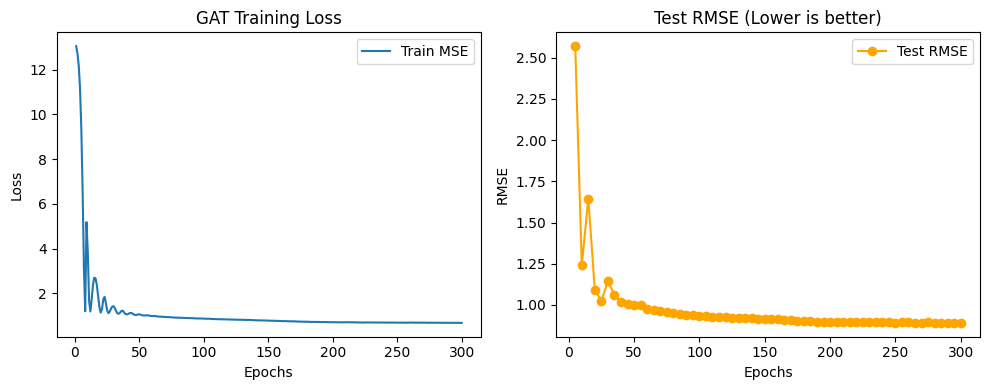


--- GAT Model Evaluation ---
Model RMSE: 0.8914
Model MAE:  0.6850
Model R^2:  0.2777

--- Example Prediction ---
User ID (internal): 431
Item ID (internal): 5340
Actual Rating: 4.5
Predicted Rating: 2.66


In [10]:
# ==========================================
# Visualisation & Prediction
# ==========================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, HP['epochs'] + 1), loss_history, label='Train MSE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GAT Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eval_epochs, test_rmse_history, label='Test RMSE', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Test RMSE (Lower is better)')
plt.legend()

plt.tight_layout()
plt.show()

# ==========================================
# Evaluation
# ==========================================
def evaluate_model_comprehensive(model, test_users, test_items, test_ratings, edge_index):
    model.eval()
    with torch.no_grad():
        embeddings = model(edge_index)
        preds = model.predict(embeddings, test_users, test_items)
        preds = torch.clamp(preds, 0.5, 5.0).cpu().numpy()
        truth = test_ratings.cpu().numpy()
        
        rmse = np.sqrt(mean_squared_error(truth, preds))
        mae = mean_absolute_error(truth, preds)
        r2 = r2_score(truth, preds)
        
        print("\n--- GAT Model Evaluation ---")
        print(f"Model RMSE: {rmse:.4f}")
        print(f"Model MAE:  {mae:.4f}")
        print(f"Model R^2:  {r2:.4f}")

evaluate_model_comprehensive(model, test_users_input, test_items_input, test_ratings, edge_index)

print("\n--- Example Prediction ---")
model.eval()
with torch.no_grad():
    # Pick first test sample
    sample_u = test_users_input[0].item()
    sample_i = test_items_input[0].item()
    sample_true = test_ratings[0].item()
    
    final_embs = model(edge_index)
    pred_rating = model.predict(
        final_embs, 
        torch.tensor([sample_u], device=HP['device']), 
        torch.tensor([sample_i], device=HP['device'])
    ).item()
    
    print(f"User ID (internal): {sample_u}")
    print(f"Item ID (internal): {sample_i}")
    print(f"Actual Rating: {sample_true}")
    print(f"Predicted Rating: {pred_rating:.2f}")